In [1]:
import os
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

2024-12-19 16:02:05.812801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 16:02:06.563623: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 16:02:08.128626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/abdo/miniconda3/envs/tf/lib/
2024-12-19 16:02:08.129394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [4]:
def get_class_counts(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            num_images = len([file for file in os.listdir(class_dir)
                              if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff'))])
            class_counts[class_name] = num_images
    return class_counts

def plot_class_distribution(class_counts, title='Class Distribution'):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

def augment_data(input_dir, output_dir, target_num_images, datagen):
    os.makedirs(output_dir, exist_ok=True)
    images = [img for img in os.listdir(input_dir) if img.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff'))]
    total_images = len(images)
    num_augmented_images = 0
    index = 0
    
    while total_images + num_augmented_images < target_num_images:
        img_name = images[index % total_images]
        img_path = os.path.join(input_dir, img_name)
        image = load_img(img_path)
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape)
        
        save_prefix = os.path.splitext(img_name)[0]
        save_to_dir = output_dir
        batch = datagen.flow(x, batch_size=1, save_to_dir=save_to_dir,
                             save_prefix=save_prefix, save_format='jpeg')
        # Generate one augmented image
        batch.next()
        num_augmented_images +=1
        index += 1
    print(f'Generated {num_augmented_images} augmented images for {os.path.basename(input_dir)}')


In [5]:
# Dataset directory (change as needed)
dataset_dir = "../Data/processed/dataset1"

# Subdirectories for train and test sets
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Verify directories exist
if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    print('Invalid dataset directory structure. Ensure it contains "train" and "test" subdirectories.')
    

Training Data Class Counts:
anger: 2574 images
contempt: 2296 images
disgust: 1981 images
fear: 2540 images
happy: 4035 images
neutral: 4100 images
sad: 2472 images
surprise: 3231 images


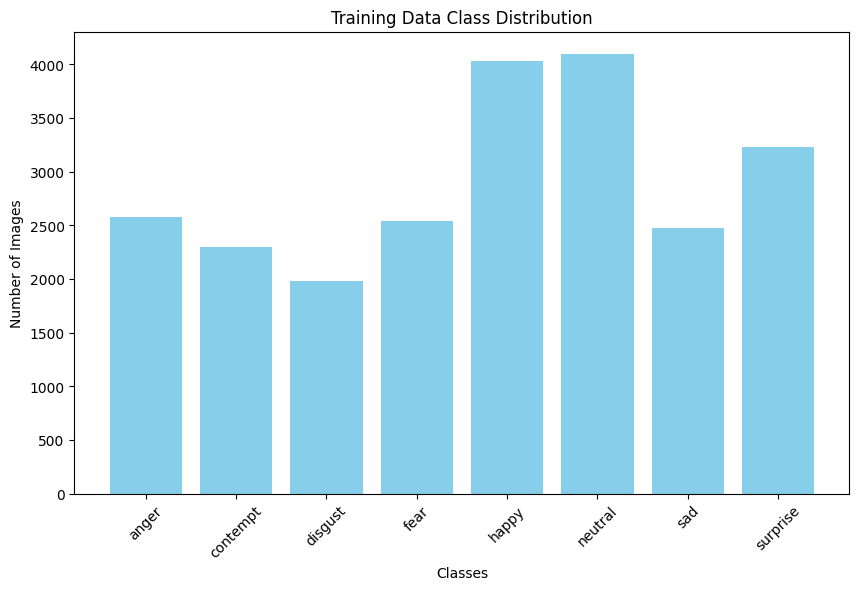

In [6]:
# Get class counts for training data
train_class_counts = get_class_counts(train_dir)

# Display class distribution
print('Training Data Class Counts:')
for class_name, count in train_class_counts.items():
    print(f'{class_name}: {count} images')

# Plot class distribution
plot_class_distribution(train_class_counts, title='Training Data Class Distribution')

Test Data Class Counts:
anger: 644 images
contempt: 575 images
disgust: 496 images
fear: 636 images
happy: 1009 images
neutral: 1026 images
sad: 619 images
surprise: 808 images


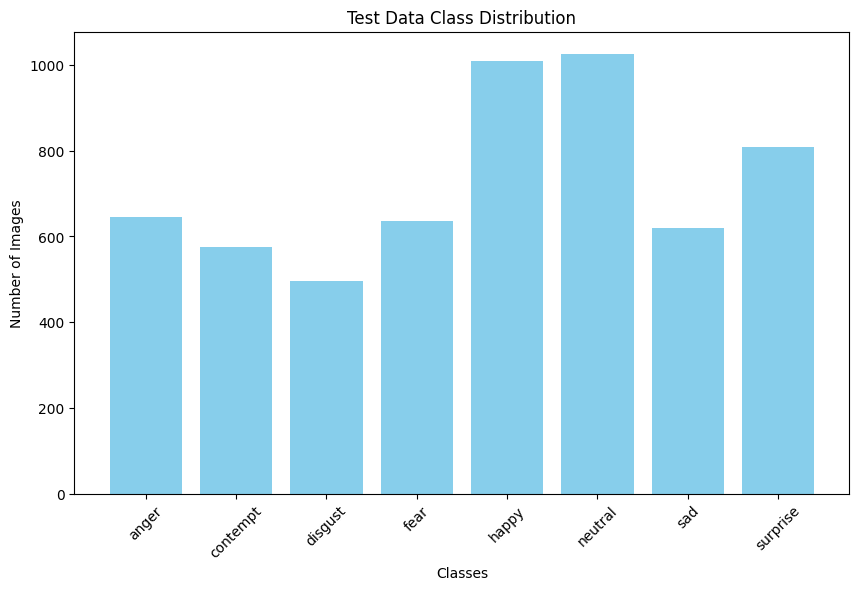

In [7]:
# Get class counts for test data
test_class_counts = get_class_counts(test_dir)

# Display class distribution
print('Test Data Class Counts:')
for class_name, count in test_class_counts.items():
    print(f'{class_name}: {count} images')

# Plot class distribution
plot_class_distribution(test_class_counts, title='Test Data Class Distribution')

In [8]:
# Compute ratios
total_train_images = sum(train_class_counts.values())
print('\nClass Ratios in Training Data:')
for class_name, count in train_class_counts.items():
    ratio = count / total_train_images
    print(f'{class_name}: {ratio:.2%}')

total_test_images = sum(test_class_counts.values())
print('\nClass Ratios in Test Data:')
for class_name, count in test_class_counts.items():
    ratio = count / total_test_images
    print(f'{class_name}: {ratio:.2%}')


Class Ratios in Training Data:
anger: 11.08%
contempt: 9.88%
disgust: 8.53%
fear: 10.93%
happy: 17.37%
neutral: 17.65%
sad: 10.64%
surprise: 13.91%

Class Ratios in Test Data:
anger: 11.08%
contempt: 9.89%
disgust: 8.53%
fear: 10.94%
happy: 17.36%
neutral: 17.65%
sad: 10.65%
surprise: 13.90%


In [9]:
# Find the class with the maximum number of images
max_images = max(train_class_counts.values())
print(f'\nTarget number of images per class: {max_images}')


Target number of images per class: 4100


In [ ]:
# Common augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Output directory for augmented data
augmented_dir = dataset_dir.rstrip('/') + '_augmented_balanced'
train_augmented_dir = os.path.join(augmented_dir, 'train')
os.makedirs(train_augmented_dir, exist_ok=True)

for class_name, count in train_class_counts.items():
    print(f'\nProcessing class: {class_name}')
    input_class_dir = os.path.join(train_dir, class_name)
    output_class_dir = os.path.join(train_augmented_dir, 'train', class_name)
    os.makedirs(output_class_dir, exist_ok=True)
    
    # Copy original images
    for img_file in os.listdir(input_class_dir):
        if img_file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff')):
            shutil.copy(os.path.join(input_class_dir, img_file), output_class_dir)
    
    # Perform augmentation if needed
    if count < max_images:
        augment_data(
            input_dir=input_class_dir,
            output_dir=output_class_dir,
            target_num_images=max_images,
            datagen=datagen
        )
    else:
        print(f'No augmentation needed for class {class_name}')

In [ ]:
# Copy test data as is
test_augmented_dir = os.path.join(augmented_dir, 'test')
shutil.copytree(test_dir, test_augmented_dir, dirs_exist_ok=True)
print('\nTest data copied to augmented dataset without changes.')

In [ ]:
# Get class counts for augmented training data
augmented_train_class_counts = get_class_counts(train_augmented_dir)

# Display class distribution
print('\nAugmented Training Data Class Counts:')
for class_name, count in augmented_train_class_counts.items():
    print(f'{class_name}: {count} images')

# Plot augmented class distribution
plot_class_distribution(augmented_train_class_counts, title='Augmented Training Data Class Distribution')